In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Tensorflow Version 2.6.0


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install scikit-learn>=0.24
!pip install ktrain # for BERT model

In [39]:
df = pd.read_csv('/content/drive/MyDrive/datagram/data/train_datam.csv')
df

,Unnamed: 0,category_id,pname
0,0,403,"Double concentré de tomates MUTTI, tube de 130g"
1,1,837,Pur jus de pommes pressées Pure Prémium TROPIC...
2,2,485,Rillettes de poulet rôti en cocotte
3,3,363,My Eyes - Taille-crayons 3 diamètres
4,4,591,Brosse à dents Inter Espaces médium AQUAFRESH
...,...,...,...
161875,162161,372,"Lait pour le corps bio à l'aloé véra SO BIO, 4..."
161876,162162,510,"Hacao aux crevettes + 2 sauces soja, 200g"
161877,162163,587,"Studio Line - Indestuctible 9, gel fixation ex..."
161878,162164,411,BISCUITS POIREAU 100G


In [40]:
del df['Unnamed: 0']
df.columns = ['category_id', 'pname']
df.head()

,category_id,pname
0,403,"Double concentré de tomates MUTTI, tube de 130g"
1,837,Pur jus de pommes pressées Pure Prémium TROPIC...
2,485,Rillettes de poulet rôti en cocotte
3,363,My Eyes - Taille-crayons 3 diamètres
4,591,Brosse à dents Inter Espaces médium AQUAFRESH


In [41]:
"""import random
random_idx_list = [random.randint(1,len(df.tweet)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it"""

'import random\nrandom_idx_list = [random.randint(1,len(df.tweet)) for i in range(10)] # creates random indexes to choose from dataframe\ndf.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it'

In [42]:
"""stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"""

'stop_words = stopwords.words(\'english\')\nstemmer = SnowballStemmer(\'english\')\n\ntext_cleaning_re = "@\\S+|https?:\\S+|http?:\\S|[^A-Za-z0-9]+'

In [43]:
"""def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)"""

'def preprocess(text, stem=False):\n  text = re.sub(text_cleaning_re, \' \', str(text).lower()).strip()\n  tokens = []\n  for token in text.split():\n    if token not in stop_words:\n      if stem:\n        tokens.append(stemmer.stem(token))\n      else:\n        tokens.append(token)\n  return " ".join(tokens)'

In [44]:
"""df.tweet = df.tweet.apply(lambda x: preprocess(x))"""

'df.tweet = df.tweet.apply(lambda x: preprocess(x))'

In [45]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [53]:
df['tweet'] = df['pname'] 
df['label'] = df['category_id']  

In [54]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set

test_data = test_data.groupby('category_id').filter(lambda x : (x['category_id'].count()>=10).any())
train_data = train_data.groupby('category_id').filter(lambda x : (x['category_id'].count()>=10).any())                               
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 129504
Test Data size 32205


In [55]:
train_data.head(10)

,category_id,pname,tweet,label
27381,377,Fines mousses au saumon-poulet-dinde-rognons p...,Fines mousses au saumon-poulet-dinde-rognons p...,377
158645,393,"Haricots beurre extra-fins d'Aucy, 2x4/4, 880g","Haricots beurre extra-fins d'Aucy, 2x4/4, 880g",393
44090,349,Savon détachant écologique à l'huile d'olive b...,Savon détachant écologique à l'huile d'olive b...,349
23089,467,*BLEU DES NEIGES 500G,*BLEU DES NEIGES 500G,467
161552,386,Olives vertes farcies au poivron goût piment,Olives vertes farcies au poivron goût piment,386
49802,610,Mouchoirs,Mouchoirs,610
11173,526,Tarte au chocolat Pierron 400g,Tarte au chocolat Pierron 400g,526
87452,363,"Trousse petit modèle, Ca612 DESSANGE","Trousse petit modèle, Ca612 DESSANGE",363
116463,600,Rasoir pour homme sensitive skinguard GILLETTE...,Rasoir pour homme sensitive skinguard GILLETTE...,600
102295,597,"Gel douche tonifiant NATURA SIBERICA, 400ml","Gel douche tonifiant NATURA SIBERICA, 400ml",597


In [56]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 28867


In [57]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (129504, 30)
Testing X Shape: (32205, 30)


In [58]:
labels = train_data.label.unique().tolist()

In [59]:
encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

y_train = encoder.transform(train_data.label.to_list())
y_test = encoder.transform(test_data.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (129504, 1)
y_test shape: (32205, 1)


In [60]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-09-25 19:21:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-25 19:21:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-25 19:21:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [82]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 100
MODEL_PATH = '/content/drive/MyDrive/Classroom/best_model.hdf5'

In [83]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [84]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [85]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [86]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [87]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(len(labels), activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [88]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [89]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [90]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/100
127/127 [==============================] - 63s 450ms/step - loss: 4.1359 - accuracy: 0.1769 - val_loss: 2.6581 - val_accuracy: 0.4081
Epoch 2/100
127/127 [==============================] - 57s 448ms/step - loss: 2.5715 - accuracy: 0.4166 - val_loss: 2.0043 - val_accuracy: 0.5308
Epoch 3/100
127/127 [==============================] - 56s 440ms/step - loss: 2.1415 - accuracy: 0.4987 - val_loss: 1.7144 - val_accuracy: 0.5924
Epoch 4/100
127/127 [==============================] - 56s 442ms/step - loss: 1.9221 - accuracy: 0.5431 - val_loss: 1.5663 - val_accuracy: 0.6221
Epoch 5/100
127/127 [==============================] - 56s 442ms/step - loss: 1.7837 - accuracy: 0.5709 - val_loss: 1.4633 - val_accuracy: 0.6438
Epoch 6/100
127/127 [==============================] - 57s 445ms/step - loss: 1.6840 - accuracy: 0.5911 - val_loss: 1.3829 - val_accuracy: 0.6641
Epoch 7/100
127/127 [==============================] - 56s 443ms/step - loss: 1.6090 - accuracy: 0.6067 - val_loss: 1.3279 -

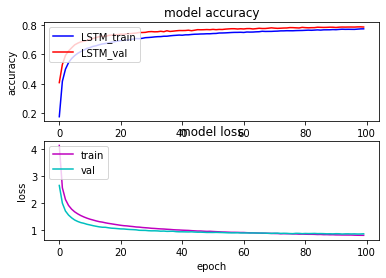

In [91]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [105]:
def decode_sentiment(score):
    return np.argmax(score) 


y_pred_1d = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]
y_pred_1d

4/4 [==============================] - 1s 140ms/step


[196,
 228,
 198,
 169,
 214,
 142,
 40,
 58,
 124,
 101,
 147,
 132,
 95,
 185,
 27,
 200,
 10,
 67,
 95,
 15,
 127,
 182,
 185,
 140,
 34,
 147,
 124,
 43,
 27,
 138,
 134,
 145,
 130,
 92,
 75,
 233,
 94,
 110,
 179,
 119,
 264,
 10,
 51,
 134,
 140,
 140,
 34,
 46,
 267,
 228,
 64,
 46,
 194,
 75,
 55,
 229,
 34,
 239,
 170,
 240,
 32,
 34,
 72,
 186,
 241,
 46,
 34,
 241,
 48,
 110,
 93,
 40,
 39,
 178,
 110,
 70,
 223,
 129,
 226,
 146,
 65,
 65,
 46,
 96,
 226,
 199,
 38,
 43,
 70,
 130,
 120,
 186,
 178,
 169,
 241,
 46,
 221,
 170,
 95,
 46,
 64,
 216,
 234,
 97,
 122,
 226,
 264,
 120,
 130,
 199,
 127,
 224,
 134,
 34,
 140,
 142,
 51,
 186,
 170,
 140,
 130,
 167,
 39,
 39,
 235,
 223,
 39,
 15,
 185,
 170,
 44,
 185,
 21,
 218,
 228,
 233,
 187,
 160,
 142,
 122,
 267,
 51,
 99,
 146,
 207,
 105,
 237,
 122,
 23,
 61,
 95,
 83,
 222,
 78,
 73,
 221,
 46,
 170,
 64,
 243,
 92,
 96,
 38,
 49,
 222,
 15,
 51,
 105,
 153,
 153,
 221,
 12,
 70,
 130,
 236,
 140,
 123,
 127,
 15

In [106]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [ ]:
"""cnf_matrix = confusion_matrix(test_data.label.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.label.unique(), title="Confusion matrix")
plt.show()"""

In [108]:
print(classification_report(list(test_data.label), y_pred_1d))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       0.0
          12       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       0.0
          14       0.00      0.00      0.00       0.0
          15       0.00      0.00      0.00       0.0
          16       0.00      0.00      0.00       0.0
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  
